Modules

In [1]:
import os
import sys
sys.path.append('..')

In [2]:
import math
import numpy as np
import biota.models as biomodels
import matplotlib.pyplot as plt

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Specify cell parameters and create instance of cell class from them. Values are derived from the un-enhanced CHO model of Humbird https://doi.org/10.31224/osf.io/795su for the two doublings production scenario.

In [3]:
growthRate = 0.029

glutamineUptakeRate = 0
glucoseUptakeRate = 0

#select desired O2 uptake rate
#oxygenUptakeRate = 0.48963 
oxygenUptakeRate = 0.49738

uptakeList = [glutamineUptakeRate, glucoseUptakeRate, oxygenUptakeRate]

#select desired CO2, ammonia, lactate production rates
carbonDioxideProdRate = 0.598906
#carbonDioxideProdRate = 0.593197

#ammoniaProductionRate = 0.013571 
ammoniaProductionRate = 0.005392

#lactateProductionRate = 0.135707 
lactateProductionRate = 0.053917

prodList = [carbonDioxideProdRate, ammoniaProductionRate, lactateProductionRate]

massDensity = 1030
cellRadius = 18e-6
wetmass = 3000
dryMassFraction = 0.3

ammoniaLimit = 5
lactateLimit = 50
CO2Limit = 100
turbLengthLimit = 20e-6
limitsList = [ammoniaLimit, lactateLimit, CO2Limit, turbLengthLimit]


cell_Humbird = biomodels.Cell(mu=growthRate,uptakes=uptakeList,prod=prodList,rho=massDensity,rad=cellRadius,wetmass=wetmass,dmf=dryMassFraction,limits=limitsList)

---------------------------------------------

Specify bioreactor parameters and then loop over a volume range to generate oxygen, carbon dioxide and mixing yield limits as in Humbird https://doi.org/10.31224/osf.io/795su.

In [4]:
count = 100 
cell = cell_Humbird
doublings = 5
rpmlims = (10,100)
supervellims = (0.0001,0.006)
celldenslims = (5.9e5,6.1e5)
showGraphs = False


rpm = 42.3
backPressure = 1.33
superficialVel = 0.004

#select inlet gas oxygen concentration
#moleFracO2 = 0.21
moleFracO2 = 0.9

moleFracCO2 = 0.03

initCells =4e6
temp = 310
powerNumber = 5
mediumDensity = 1000
mediumViscosity = 8e-4
vesselVolDay = 0.0
perfLactateRate = 5.0
perfAmmrate = 5.0

vols = np.logspace(0,2.3,base=10,num=20)
O2 = np.zeros((vols.shape[0]))
CO2 = np.zeros((vols.shape[0]))
Mixing = np.zeros((vols.shape[0]))
NH3 = np.zeros((vols.shape[0]))

for c,i in enumerate(vols):
    workingVolume = i*1000
    initVol = 0.8 * workingVolume
    tankDiameter = (i*4/math.pi/2)**(1/3)
    impellerDiameter = tankDiameter/3
    reactor = biomodels.Bioreactor(wv=workingVolume,t=tankDiameter,d=impellerDiameter,n=rpm,p_back=backPressure,u_s=superficialVel,mf_O2_gas=moleFracO2,mf_CO2_gas=moleFracCO2,v0=initVol,ns=initCells,Temp=temp,
                                     Np=powerNumber,rho=mediumDensity,mu=mediumViscosity,vvd=vesselVolDay,perfAMM=perfAmmrate,perfLAC=perfLactateRate)

    a = biomodels.brute(count=count,b=reactor,c=cell,dbls=doublings,rpmlims=rpmlims,uslims=supervellims,nslims=celldenslims,graphs=showGraphs)
    O2[c] = a.iloc[4][1]
    CO2[c] = a.iloc[3][1]
    NH3[c] = a.iloc[1][1]
    Mixing[c] = a.iloc[5][1]

/var/folders/pq/hnn9vcj54gz4mqm3jxlqhp400000gn/T/ipykernel_95552/1917040983.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  O2[c] = a.iloc[4][1]
/var/folders/pq/hnn9vcj54gz4mqm3jxlqhp400000gn/T/ipykernel_95552/1917040983.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  CO2[c] = a.iloc[3][1]
/var/folders/pq/hnn9vcj54gz4mqm3jxlqhp400000gn/T/ipykernel_95552/1917040983.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NH3[c]

---------------------------------------------------------------------------------------------------------------------------------------------------------------

Save previous oxygen and mixing performance to compare effects of using one or two impellers in the evaluation of maximum eddy dissipation rate

In [5]:
#np.save('o2.npy',O2)
#np.save('mixing2.npy',Mixing)

#O2_2 = np.load('o2.npy')
#Mixing_2 = np.load('mixing2.npy')


-----------------------------------------

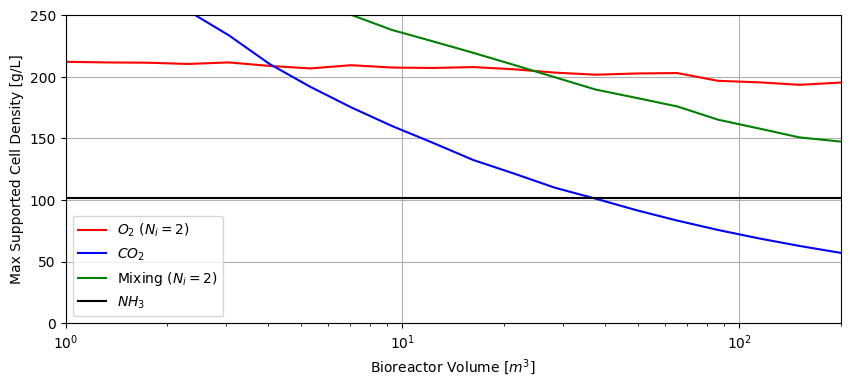

In [6]:
plt.figure(figsize=(10,4))
plt.plot(vols,O2,color='red',label="$O_2$ ($N_i=2$)")
#plt.plot(vols,O2_2,color='red',linestyle='dashed',label="$O_2$ ($N_i=1$)")
plt.plot(vols,CO2,color='blue',label="$CO_2$")
plt.plot(vols,Mixing,color='green',label="Mixing ($N_i=2$)")
#plt.plot(vols,Mixing_2,color='green',linestyle='dashed',label="Mixing ($N_i=1$)")
plt.plot(vols,NH3,color='black',label=r"$NH_3$")

plt.legend()
plt.xscale('log')
plt.ylim((0,250))
plt.xlim((1,200))
plt.xlabel('Bioreactor Volume [$m^3$]')
plt.ylabel('Max Supported Cell Density [g/L]')
plt.grid()
plt.show()

-------------------------------------------------